# Ellucidate patters of understanding from the model

1. Amino acid distributions
2. Disulfide bond
3. Model attention
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import os
import MDAnalysis
sns.set_style('ticks')
sns.set_context('talk')

## Loss

In [2]:
ds = datasets.load_from_disk('../data/nomelt-model/test_embeddings')

In [12]:
total_loss = 0.0
sum(ds['token_mean_loss'].reshape(-1) * ds['thermo_seq_len'].reshape(-1))/sum(ds['thermo_seq_len'])

tensor(0.1848)

## AA distributions

In [6]:
df = pd.read_csv('../data/nomelt-model/predictions.tsv', sep='\t', header=None)

In [12]:
df = df.melt(var_name='which', value_name='seq')
df

,which,seq
0,0,M I D E T L L E A E E K M D K A V E V A K E D ...
1,0,M G A A A L T S Q S F I R S I Q S G V C L V D ...
2,0,M A L R G V V A M D G P S G T G K S T V S R R ...
3,0,M S A S L V V F D L D G T L I D T A H D L V A ...
4,0,M S K I T E Q I E A M A Q P I I D E L E L E L ...
...,...,...
3019,2,M A R Y R G P K Q K I A R R F G E P I F G P S ...
3020,2,M R K I R K G D E V V V L A G K D K G R R G A ...
3021,2,M D K R Q P P A I G K N I A N Y R K Q K G M S ...
3022,2,M P R S T A R R E E I L A V A G E L F R Q K G ...


In [14]:
map = {0: 'meso', 1:'thermo', 2:'generated'}
df['which'] = df['which'].apply(map.get)

In [15]:
df['seq'] = df['seq'].apply(lambda s: ''.join(s.split()))
df

,which,seq
0,meso,MIDETLLEAEEKMDKAVEVAKEDFATIRTGRANPAMFSKITVDYYG...
1,meso,MGAAALTSQSFIRSIQSGVCLVDFWAVWCGPCKIQLPIVNELADEL...
2,meso,MALRGVVAMDGPSGTGKSTVSRRLAQACSAAYLDTGAMYRAATLAV...
3,meso,MSASLVVFDLDGTLIDTAHDLVASLNHTIGIEGLEPVGFGDLTYLV...
4,meso,MSKITEQIEAMAQPIIDELELELVDVEFVKEGKNWFLRVYVDNPQE...
...,...,...
3019,generated,MARYRGPKQKIARRFGEPIFGPSKALERKPYPPGQHGRTRRAKESE...
3020,generated,MRKIRKGDEVVVLAGKDKGRRGAVLRVLPDDRVIVEGVNMVKKHVK...
3021,generated,MDKRQPPAIGKNIANYRKQKGMSMDELAKKSGVSKSMLSQIEQEKT...
3022,generated,MPRSTARREEILAVAGELFRQKGYHATSMQDIAERLQLQRGSLYAH...


In [18]:
unique_amino_acids = set(''.join(df['seq']))
unique_amino_acids

{'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y'}

In [19]:
for aa in unique_amino_acids:
    df[aa] = 0.0

# Calculate propensities
for index, row in df.iterrows():
    sequence = row['seq']
    sequence_length = len(sequence)
    for aa in unique_amino_acids:
        aa_count = sequence.count(aa)
        propensity = aa_count / sequence_length
        df.at[index, aa] = propensity

In [22]:
props = df.groupby('which').mean()

/tmp/ipykernel_24156/1232505406.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  props = df.groupby('which').mean()


In [25]:
props = props.T.sort_values(by='meso').T

In [26]:
props

,W,C,H,Y,M,N,F,Q,P,K,S,T,I,D,E,R,G,V,L,A
which,,,,,,,,,,,,,,,,,,,,
generated,0.007241,0.008660,0.017126,0.027478,0.025108,0.032689,0.032752,0.026243,0.038122,0.067467,0.040999,0.043397,0.071521,0.052169,0.082027,0.070206,0.077590,0.085586,0.104134,0.089484
meso,0.007712,0.007859,0.020668,0.021875,0.025761,0.028911,0.030002,0.031216,0.039216,0.047057,0.048766,0.053590,0.058719,0.060911,0.067814,0.069236,0.081799,0.087864,0.102704,0.108320
thermo,0.006762,0.009726,0.015166,0.028342,0.027224,0.032479,0.033129,0.025415,0.036770,0.069096,0.040800,0.043727,0.070339,0.052759,0.083147,0.069659,0.078755,0.087873,0.096914,0.091916


In [34]:
from io import StringIO

https://www.sciencedirect.com/science/article/pii/S0378111903006607?via%3Dihub

In [36]:
lit_values = pd.read_csv(StringIO("""Amino acids (abbr.),Mean (mesophiles),Mean (thermophiles),Mean difference,p-value
Alanine (A),94.0,72.3,-21.6,0.00531
Cysteine (C),11.6,8.4,-3.1,0.04834
Aspartate (D),51.1,49.8,-1.2,0.64566
Glutamate (E),59.8,82.4,22.6,0.00250
Phenylalanine (F),40.4,44.8,4.4,0.13040
Glycine (G),72.6,73.2,0.6,0.77827
Histidine (H),23.5,16.0,-7.5,0.00001
Isoleucine (I),60.1,76.4,16.3,0.00238
Lysine (K),47.4,68.3,20.9,0.01555
Leucine (L),105.8,98.5,-7.3,0.06444
Methionine (M),22.2,21.7,-0.5,0.82140
Asparagine (N),37.4,34.3,-3.1,0.24733
Proline (P),44.0,42.1,-1.8,0.38922
Glutamine (Q),44.9,19.6,-25.3,0.00000
Arginine (R),56.2,58.5,2.3,0.57911
Serine (S),60.7,56.7,-4.0,0.33203
Threonine (T),54.3,44.8,-9.5,0.00005
Valine (V),71.1,82.3,11.1,0.00519
Tryptophan (W),13.3,10.6,-2.7,0.03046
Tyrosine (Y),29.8,39.2,9.4,0.00140

"""))

In [37]:
lit_values

,Amino acids (abbr.),Mean (mesophiles),Mean (thermophiles),Mean difference,p-value
0,Alanine (A),94.0,72.3,-21.6,0.00531
1,Cysteine (C),11.6,8.4,-3.1,0.04834
2,Aspartate (D),51.1,49.8,-1.2,0.64566
3,Glutamate (E),59.8,82.4,22.6,0.00250
4,Phenylalanine (F),40.4,44.8,4.4,0.13040
5,Glycine (G),72.6,73.2,0.6,0.77827
6,Histidine (H),23.5,16.0,-7.5,0.00001
7,Isoleucine (I),60.1,76.4,16.3,0.00238
8,Lysine (K),47.4,68.3,20.9,0.01555
9,Leucine (L),105.8,98.5,-7.3,0.06444


In [39]:
import re

In [48]:
lit_values['AA'] = lit_values['Amino acids (abbr.)'].apply(lambda s: re.search('\(.*?\)', s).group(0)[1])
lit_values['sig'] = lit_values['p-value'] < 0.05

In [49]:
lit_values

,Amino acids (abbr.),Mean (mesophiles),Mean (thermophiles),Mean difference,p-value,AA,sig
0,Alanine (A),94.0,72.3,-21.6,0.00531,A,True
1,Cysteine (C),11.6,8.4,-3.1,0.04834,C,True
2,Aspartate (D),51.1,49.8,-1.2,0.64566,D,False
3,Glutamate (E),59.8,82.4,22.6,0.00250,E,True
4,Phenylalanine (F),40.4,44.8,4.4,0.13040,F,False
5,Glycine (G),72.6,73.2,0.6,0.77827,G,False
6,Histidine (H),23.5,16.0,-7.5,0.00001,H,True
7,Isoleucine (I),60.1,76.4,16.3,0.00238,I,True
8,Lysine (K),47.4,68.3,20.9,0.01555,K,True
9,Leucine (L),105.8,98.5,-7.3,0.06444,L,False


In [52]:
sig_dict = lit_values[['AA', 'sig']].set_index('AA')['sig'].to_dict()
sig_dict

{'A': True,
 'C': True,
 'D': False,
 'E': True,
 'F': False,
 'G': False,
 'H': True,
 'I': True,
 'K': True,
 'L': False,
 'M': False,
 'N': False,
 'P': False,
 'Q': True,
 'R': False,
 'S': False,
 'T': True,
 'V': True,
 'W': True,
 'Y': True}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


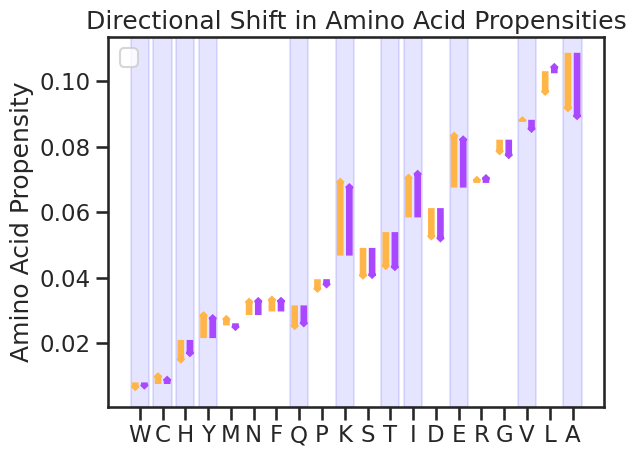

In [54]:
# Calculate shifts
shift_to_thermo = props.loc['thermo'] - props.loc['meso']
shift_to_generated = props.loc['generated'] - props.loc['meso']

# Plotting
labels = props.columns
x = np.arange(len(labels))

fig, ax = plt.subplots()

# Plot initial 'meso' values
meso_values = props.loc['meso']
# ax.scatter(x, meso_values, label='Initial (meso)', c='blue')

for i, label in enumerate(labels):
    if sig_dict.get(label, False):  # Check if the boolean is True for this amino acid
        ax.axvspan(i - 0.4, i + 0.4, color='blue', alpha=0.1)

# Draw arrows for shifts
for i, label in enumerate(labels):
    ax.arrow(i - 0.2, meso_values[label], 0, shift_to_thermo[label], width=0.2, head_width=0.3, head_length=0.001, fc='#FFB548', ec='#FFB548')
    ax.arrow(i + 0.2, meso_values[label], 0, shift_to_generated[label], width=0.2, head_width=0.3, head_length=0.001, fc='#AA48FF', ec='#AA48FF')

ax.set_ylabel('Amino Acid Propensity')
ax.set_title('Directional Shift in Amino Acid Propensities')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

We recapitualte the data distribution shift for all significant amino acids.

## Disulfide bonds

### number

In [56]:
ds_data = df[['which', 'seq']].copy()
ds_data

,which,seq
0,meso,MIDETLLEAEEKMDKAVEVAKEDFATIRTGRANPAMFSKITVDYYG...
1,meso,MGAAALTSQSFIRSIQSGVCLVDFWAVWCGPCKIQLPIVNELADEL...
2,meso,MALRGVVAMDGPSGTGKSTVSRRLAQACSAAYLDTGAMYRAATLAV...
3,meso,MSASLVVFDLDGTLIDTAHDLVASLNHTIGIEGLEPVGFGDLTYLV...
4,meso,MSKITEQIEAMAQPIIDELELELVDVEFVKEGKNWFLRVYVDNPQE...
...,...,...
3019,generated,MARYRGPKQKIARRFGEPIFGPSKALERKPYPPGQHGRTRRAKESE...
3020,generated,MRKIRKGDEVVVLAGKDKGRRGAVLRVLPDDRVIVEGVNMVKKHVK...
3021,generated,MDKRQPPAIGKNIANYRKQKGMSMDELAKKSGVSKSMLSQIEQEKT...
3022,generated,MPRSTARREEILAVAGELFRQKGYHATSMQDIAERLQLQRGSLYAH...


In [65]:
ds_data['C_count'] = ds_data['seq'].apply(lambda s: (np.array(list(s)) =='C').sum())

<AxesSubplot: xlabel='C_count', ylabel='Count'>

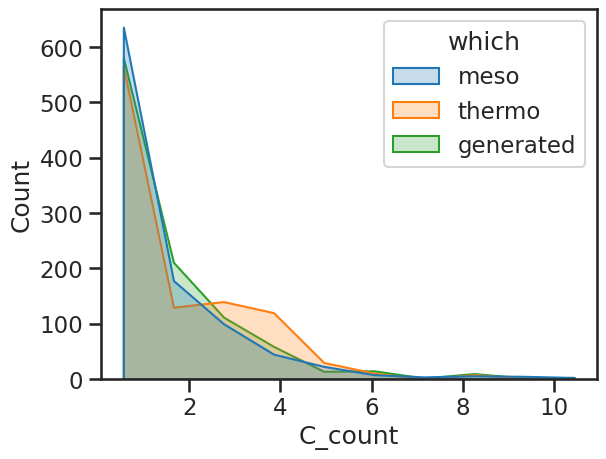

In [69]:
sns.histplot(ds_data, x='C_count', hue='which', element="poly", bins=10)

### Look at 3d structure

Need to estimate disulfide bonds in contact with eachother for thermophilic proteins. This requires structure prediction and then residue distance evaluation. Then we will look at disulfide bond proteins and the AA probabilities of the second residue in the bond, and show that it is higher than a random cystein not part of a bond.

In [2]:
df = pd.read_csv('../data/nomelt-model/predictions.tsv', sep='\t', header=None)
df = df.rename(columns={0:'meso', 1:'thermo', 2:'generated'})

In [3]:
df = df.applymap(lambda s: ''.join(s.split()))

In [4]:
df['C_count'] = df['thermo'].apply(lambda s: (np.array(list(s)) =='C').sum())

In [5]:
df = df[df['C_count'] > 0]

In [6]:
df

,meso,thermo,generated,C_count
1,MGAAALTSQSFIRSIQSGVCLVDFWAVWCGPCKIQLPIVNELADEL...,MSDDILQVTDATFETEVLGSELPVLVDFWAEWCGPCKMIAPILEEV...,MKPVNVTDETFAEEVYNSNKPVLVDFWAKWCRPCLMMAPVLEEFAE...,2
2,MALRGVVAMDGPSGTGKSTVSRRLAQACSAAYLDTGAMYRAATLAV...,MKRVIAIDGPAGAGKSTVARRVATALGYLYVDTGAMYRAMTLKVLR...,MKRVIAIDGPAGAGKSTVARRVATALGYLYVDTGAMYRAMTLKVLR...,2
3,MSASLVVFDLDGTLIDTAHDLVASLNHTIGIEGLEPVGFGDLTYLV...,MRLIVFDWDGTLMDSEARIVSCIQAAAREMGLAPLARERAREVIGL...,MNVKAVIFDLDGTLIDSKKDIVIAANRAFSEFNLPTLPEEILASFI...,5
4,MSKITEQIEAMAQPIIDELELELVDVEFVKEGKNWFLRVYVDNPQE...,MSHRKVEAAVEAVAAPLAEARGLVLLDVAYRREGRRWFLQCVVDRP...,MSKITKKVEELVKPILERYGFDLVDIEFKKEGKSHFLRVYIDKPGG...,2
5,MVLWGAIVNAAAIAAGTFAGLLLPRLHANLRTIATQGMGLALCVLG...,MIGLGTIVNAAAVIVGSILGLVLKFGIPERFKSTIMQAISLSVIFI...,MLGTIVNFVAILLGGSIGVFFKKSLPENYKEIVMNILALSVVVVGI...,1
...,...,...,...,...
1003,MARYIGPTCKLARREGADLSLKSPARALDSKCKLEQKPGQHGATAR...,MAKYIGPKCRLCRREGGKLFLKGEKCYTSKCPVESRNYPPGQHGQR...,MARYRGPKQKIARRFGEPIFGPSKALERKPYPPGQHGRTRRAKESE...,4
1004,MQKIKKGDNVVVLAGKDKGQSGKVLQVMPKEDKAVVQGVNLVKKHQ...,MHVKKGDKVVVISGKDKGKVGKVLRAIPKKDRVIVEGVNMQTKHQK...,MRKIRKGDEVVVLAGKDKGRRGAVLRVLPDDRVIVEGVNMVKKHVK...,3
1005,MDPNNVGERLRALRRQRGATLAELSAATGISVSTLSRLEAGQRKPT...,MKIGEKIRQLRLKAGLTQEELADRCELTKGFISQVERELTSPSIAT...,MDKRQPPAIGKNIANYRKQKGMSMDELAKKSGVSKSMLSQIEQEKT...,2
1006,MRGRSPDRRRALLDAADRVIERDGHEVSMAAIAVEAGITKPILYRH...,MERTSTKRLPIFEAAVAVFSEKGFAKATMEEIARRAGIAKGTLYYN...,MPRSTARREEILAVAGELFRQKGYHATSMQDIAERLQLQRGSLYAH...,1


#### load structs

In [7]:
def load_one(row):
    i = row.name
    if os.path.exists(f'./tmp/cystein_analysis/{i}.pdb'):
        u = MDAnalysis.Universe(f'./tmp/cystein_analysis/{i}.pdb')
        return u
    else:
        return None

In [8]:
df['struct'] = df.apply(load_one, axis=1)

/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


#### compute structs and save

In [94]:
import esm
import torch
esm_model = esm.pretrained.esmfold_v1().eval().to('cuda')

In [105]:
import MDAnalysis

In [109]:
def get_struct(seq):
    with torch.no_grad():
        
        output = esm_model.infer_pdb(seq)
    u = MDAnalysis.Universe(StringIO(output), format='pdb')
    return u
        

In [110]:
def do_one(row):
    if row['C_count'] < 2:
        return None
    else:
        return get_struct(row['thermo'])

In [111]:
df['struct'] = df.apply(do_one, axis=1)

/tmp/ipykernel_24156/3492636441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['struct'] = df.apply(do_one, axis=1)


In [125]:
def write_one(row):
    i = row.name
    u = row['struct']
    if u is None:
        return None
    else:
        writer = MDAnalysis.coordinates.PDB.PDBWriter(f'./tmp/cystein_analysis/{i}.pdb')
        writer.write(u)
     

In [126]:
df.apply(write_one, axis=1)

/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:775: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


1       None
2       None
3       None
4       None
5       None
        ... 
1003    None
1004    None
1005    None
1006    None
1007    None
Length: 765, dtype: object

In [299]:
del esm_model

### Find examples with disulfide bonds

In [9]:
import nglview as ngl
import scipy.spatial

In [10]:
u = df['struct'].loc[3]

In [11]:
u

<Universe with 1691 atoms>

In [12]:
Cs = [r for r in u.residues if r.resname=='CYS']

In [13]:
Cs

[<Residue CYS, 22>,
 <Residue CYS, 59>,
 <Residue CYS, 132>,
 <Residue CYS, 184>,
 <Residue CYS, 205>]

In [14]:
C_neighbor_distances = scipy.spatial.distance_matrix(
    np.array([r.resid for r in Cs]).reshape(-1,1), np.array([r.resid for r in Cs]).reshape(-1,1)).astype(int)

In [15]:
C_neighbor_distances > 6

array([[False,  True,  True,  True,  True],
       [ True, False,  True,  True,  True],
       [ True,  True, False,  True,  True],
       [ True,  True,  True, False,  True],
       [ True,  True,  True,  True, False]])

In [16]:
aids = []
for r in Cs:
    aids.extend([a.id for a in r.atoms])

In [17]:
w = ngl.show_mdanalysis(u)
w.clear_representations()
w.add_representation('ribbon', color='grey')
w.add_representation('ball+stick', selection=aids)
w

/mmfs1/gscratch/cheme/usr/evankomp/mamba/mambaforge/envs/nomelt2/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:451: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


NGLWidget()

In [18]:
positions = np.vstack([r.atoms.select_atoms('name SG')[0].position for r in Cs])

In [19]:
distances = scipy.spatial.distance_matrix(positions, positions)
distances

array([[ 0.        , 18.25762539, 16.67052158, 20.05123985, 25.23241234],
       [18.25762539,  0.        , 21.22131536, 29.79368061, 36.75870883],
       [16.67052158, 21.22131536,  0.        , 20.23620343, 23.01986295],
       [20.05123985, 29.79368061, 20.23620343,  0.        ,  8.20070785],
       [25.23241234, 36.75870883, 23.01986295,  8.20070785,  0.        ]])

In [20]:
positions

array([[ -5.131, -12.496,  -8.959],
       [ -6.528,   1.703, -20.351],
       [ -9.928,   0.328,   0.551],
       [  8.942,  -6.191,   3.857],
       [  8.362,  -7.889,  11.859]], dtype=float32)

In [21]:
def find_disulfide_residues(u):
    Cs = [r for r in u.residues if r.resname=='CYS']
    C_resids = [r.resid -1 for r in Cs]
    C_neighbor_distances = scipy.spatial.distance_matrix(
        np.array([r.resid for r in Cs]).reshape(-1,1), np.array([r.resid for r in Cs]).reshape(-1,1)).astype(int)

    positions = np.vstack([r.atoms.select_atoms('name SG')[0].position for r in Cs])
    distances = scipy.spatial.distance_matrix(positions, positions)

    mask = np.logical_and(C_neighbor_distances > 6, distances < 7.5)
    pairs = list(zip(*np.where(np.triu(mask))))
    pairs = [(C_resids[i], C_resids[j]) for i, j in pairs]
    return C_resids, pairs

In [22]:
find_disulfide_residues(u)

([21, 58, 131, 183, 204], [])

In [23]:
def do_one(row):
    C_ids = [i for i, s in enumerate(row['thermo']) if s=='C']

    if row['struct'] is None:
        pairs = []
    else:
        C_ids_check, pairs = find_disulfide_residues(row['struct'])
        assert C_ids == C_ids_check, f"{C_ids}, {C_ids_check}"

    return pd.Series({'C_ids': C_ids, 'DS_bonds': pairs})

In [24]:
df[['C_ids', 'DS_bonds']] = df.apply(do_one, axis=1)

In [25]:
df['DS_count'] = df['DS_bonds'].apply(len)
df

,meso,thermo,generated,C_count,struct,C_ids,DS_bonds,DS_count
1,MGAAALTSQSFIRSIQSGVCLVDFWAVWCGPCKIQLPIVNELADEL...,MSDDILQVTDATFETEVLGSELPVLVDFWAEWCGPCKMIAPILEEV...,MKPVNVTDETFAEEVYNSNKPVLVDFWAKWCRPCLMMAPVLEEFAE...,2,<Universe with 830 atoms>,"[32, 35]",[],0
2,MALRGVVAMDGPSGTGKSTVSRRLAQACSAAYLDTGAMYRAATLAV...,MKRVIAIDGPAGAGKSTVARRVATALGYLYVDTGAMYRAMTLKVLR...,MKRVIAIDGPAGAGKSTVARRVATALGYLYVDTGAMYRAMTLKVLR...,2,<Universe with 1693 atoms>,"[46, 217]",[],0
3,MSASLVVFDLDGTLIDTAHDLVASLNHTIGIEGLEPVGFGDLTYLV...,MRLIVFDWDGTLMDSEARIVSCIQAAAREMGLAPLARERAREVIGL...,MNVKAVIFDLDGTLIDSKKDIVIAANRAFSEFNLPTLPEEILASFI...,5,<Universe with 1691 atoms>,"[21, 58, 131, 183, 204]",[],0
4,MSKITEQIEAMAQPIIDELELELVDVEFVKEGKNWFLRVYVDNPQE...,MSHRKVEAAVEAVAAPLAEARGLVLLDVAYRREGRRWFLQCVVDRP...,MSKITKKVEELVKPILERYGFDLVDIEFKKEGKSHFLRVYIDKPGG...,2,<Universe with 1202 atoms>,"[40, 53]",[],0
5,MVLWGAIVNAAAIAAGTFAGLLLPRLHANLRTIATQGMGLALCVLG...,MIGLGTIVNAAAVIVGSILGLVLKFGIPERFKSTIMQAISLSVIFI...,MLGTIVNFVAILLGGSIGVFFKKSLPENYKEIVMNILALSVVVVGI...,1,None,[125],[],0
...,...,...,...,...,...,...,...,...
1003,MARYIGPTCKLARREGADLSLKSPARALDSKCKLEQKPGQHGATAR...,MAKYIGPKCRLCRREGGKLFLKGEKCYTSKCPVESRNYPPGQHGQR...,MARYRGPKQKIARRFGEPIFGPSKALERKPYPPGQHGRTRRAKESE...,4,<Universe with 1686 atoms>,"[8, 11, 25, 30]","[(8, 25), (8, 30), (11, 25), (11, 30)]",4
1004,MQKIKKGDNVVVLAGKDKGQSGKVLQVMPKEDKAVVQGVNLVKKHQ...,MHVKKGDKVVVISGKDKGKVGKVLRAIPKKDRVIVEGVNMQTKHQK...,MRKIRKGDEVVVLAGKDKGRRGAVLRVLPDDRVIVEGVNMVKKHVK...,3,<Universe with 795 atoms>,"[71, 94, 97]","[(71, 94), (71, 97)]",2
1005,MDPNNVGERLRALRRQRGATLAELSAATGISVSTLSRLEAGQRKPT...,MKIGEKIRQLRLKAGLTQEELADRCELTKGFISQVERELTSPSIAT...,MDKRQPPAIGKNIANYRKQKGMSMDELAKKSGVSKSMLSQIEQEKT...,2,<Universe with 1425 atoms>,"[24, 52]","[(24, 52)]",1
1006,MRGRSPDRRRALLDAADRVIERDGHEVSMAAIAVEAGITKPILYRH...,MERTSTKRLPIFEAAVAVFSEKGFAKATMEEIARRAGIAKGTLYYN...,MPRSTARREEILAVAGELFRQKGYHATSMQDIAERLQLQRGSLYAH...,1,None,[100],[],0


### prepare a dataset ready for the model with positive (is a disulfide bond) and negative (just a cysteine, no bond)

In [26]:
df['C_count'].sum()

1803

In [27]:
df['DS_count'].sum()

337

In [28]:
def extract_examples(row):
    assert all([row['thermo'][i]=='C' for i in row['C_ids']])
    # determine all second-occurring cysteines within bonds and add them as positive labels
    positive_cysteines = [p[1] for p in row['DS_bonds']]
    negative_cysteines = [c for c in row['C_ids'] if c not in positive_cysteines]

    examples = []
    # add positive examples
    for p in positive_cysteines:
        examples.append((
            row['meso'], row['thermo'][:p], True
        ))
    for n in negative_cysteines:
        examples.append((
            row['meso'], row['thermo'][:n], False
        ))
    return examples

In [29]:
examples = []
for i, row in df.iterrows():
    examples.extend(extract_examples(row))

In [30]:
len(examples)

1915

In [31]:
import datasets

In [32]:
examples_dict = {
    'meso': [t[0] for t in examples],
    'partial': [t[1] for t in examples],
    'labels': [t[2] for t in examples],
}
ds = datasets.Dataset.from_dict(examples_dict)

### Call tokenizer and model on data

In [33]:
import re
import torch

In [34]:
from yaml import safe_load
with open('../params.yaml', 'r') as f:
        params = safe_load(f)

In [35]:
from transformers import T5Tokenizer

In [36]:
# load tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained('../data/nomelt-model/model')
except:
    tokenizer = T5Tokenizer.from_pretrained('../data/nomelt-model/model')

# preprocess data with tokenizer
def prepare_string(string):
    out = ' '.join(string)
    out = re.sub(r"[UZOB]", "X", out)
    return out
def preprocess_dataset_to_model_inputs(examples):
    
    in_seqs = [prepare_string(seq) for seq in examples['meso']]
    out_seqs = [prepare_string(seq) for seq in examples['partial']]

    # tokenize inputs and outputs
    model_inputs = tokenizer(in_seqs, max_length=params['model']['generation_max_length'], padding='max_length', truncation=True)
    partial_ids = torch.tensor(tokenizer(out_seqs, max_length=params['model']['generation_max_length'], padding='max_length', truncation=True)['input_ids'])
    # fill -100s to be ignored in loss
    # partial_ids = torch.where(partial_ids == tokenizer.pad_token_id, -100, partial_ids)
    model_inputs['partial_ids'] = partial_ids
    return model_inputs


You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [37]:
ds.set_format(type='torch')

In [38]:
ds = ds.map(preprocess_dataset_to_model_inputs, batched=True, desc='Tokenizing and preparing model inputs')

Tokenizing and preparing model inputs:   0%|          | 0/1915 [00:00<?, ? examples/s]

In [39]:
from transformers import AutoModelForSeq2SeqLM, AutoConfig

In [40]:
# load the model with potentially custom config
model_config = AutoConfig.from_pretrained('../data/nomelt-model/model')
for model_hyperparam in params['model']['model_hyperparams']:
    setattr(model_config, model_hyperparam, params['model']['model_hyperparams'][model_hyperparam])
setattr(model_config, 'max_length', params['model']['generation_max_length'])
MODEL = AutoModelForSeq2SeqLM.from_pretrained('../data/nomelt-model/model', config=model_config).to('cuda')

[2023-09-08 16:41:45,999] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2023-09-08 16:41:46.699297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 16:41:46.981769: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [41]:
import tqdm

In [42]:
logits = []
# Iterate over the dataset
for data in tqdm.tqdm(ds):
    # Tokenize
    input_tokens = tokenizer(prepare_string(data['meso']), return_tensors="pt", padding=True, truncation=True)
    decoder_input_tokens = tokenizer(prepare_string(data['partial']), return_tensors="pt", padding=True, truncation=True)
    # print(len(data['partial']), decoder_input_tokens.input_ids.shape)
    # Forward pass
    with torch.no_grad():
        output = MODEL(input_ids=input_tokens.input_ids.to('cuda'),
                       attention_mask=input_tokens.attention_mask.to('cuda'),
                       decoder_input_ids=decoder_input_tokens.input_ids.to('cuda'),
                       use_cache=True)
    
    # Get logits for the next token
    logits_next_token = torch.softmax(output.logits[:, -1, :], axis=-1)  # shape: (batch_size, vocab_size)
    logits.append(logits_next_token)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1915/1915 [03:25<00:00,  9.34it/s]


In [45]:
token_to_id = tokenizer.get_vocab()

In [56]:
id_to_token = {v: k.split('▁')[-1] for k, v in token_to_id.items()}

In [57]:
id_to_token

{0: '<pad>',
 1: '</s>',
 2: '<unk>',
 3: 'A',
 4: 'L',
 5: 'G',
 6: 'V',
 7: 'S',
 8: 'R',
 9: 'E',
 10: 'D',
 11: 'T',
 12: 'I',
 13: 'P',
 14: 'K',
 15: 'F',
 16: 'Q',
 17: 'N',
 18: 'Y',
 19: 'M',
 20: 'H',
 21: 'W',
 22: 'C',
 23: 'X',
 24: 'B',
 25: 'O',
 26: 'U',
 27: 'Z',
 28: '<extra_id_99>',
 29: '<extra_id_98>',
 30: '<extra_id_97>',
 31: '<extra_id_96>',
 32: '<extra_id_95>',
 33: '<extra_id_94>',
 34: '<extra_id_93>',
 35: '<extra_id_92>',
 36: '<extra_id_91>',
 37: '<extra_id_90>',
 38: '<extra_id_89>',
 39: '<extra_id_88>',
 40: '<extra_id_87>',
 41: '<extra_id_86>',
 42: '<extra_id_85>',
 43: '<extra_id_84>',
 44: '<extra_id_83>',
 45: '<extra_id_82>',
 46: '<extra_id_81>',
 47: '<extra_id_80>',
 48: '<extra_id_79>',
 49: '<extra_id_78>',
 50: '<extra_id_77>',
 51: '<extra_id_76>',
 52: '<extra_id_75>',
 53: '<extra_id_74>',
 54: '<extra_id_73>',
 55: '<extra_id_72>',
 56: '<extra_id_71>',
 57: '<extra_id_70>',
 58: '<extra_id_69>',
 59: '<extra_id_68>',
 60: '<extra_id

In [60]:
logits = torch.vstack(logits)

In [63]:
logits_df = pd.DataFrame(columns=id_to_token.values(), data=logits.cpu())

In [67]:
logits_df['label']=ds['labels']

In [68]:
logits_df

,<pad>,</s>,<unk>,A,L,G,V,S,R,E,...,<extra_id_8>,<extra_id_7>,<extra_id_6>,<extra_id_5>,<extra_id_4>,<extra_id_3>,<extra_id_2>,<extra_id_1>,<extra_id_0>,label
0,3.890460e-06,8.601119e-07,2.884291e-18,0.016980,0.089782,0.111039,0.049339,0.020504,0.016599,0.183695,...,3.715134e-18,1.725156e-18,8.283426e-18,2.395489e-18,3.241758e-18,2.151550e-18,3.845456e-18,3.998367e-18,3.222161e-07,False
1,2.736885e-06,5.956514e-08,1.352011e-16,0.016045,0.044396,0.003768,0.017368,0.011176,0.164273,0.158354,...,1.595181e-16,8.025174e-17,2.410312e-16,1.002084e-16,1.340180e-16,1.127026e-16,1.819816e-16,1.529326e-16,2.837896e-06,False
2,1.966270e-05,8.815273e-03,2.445896e-14,0.100496,0.063854,0.171648,0.021759,0.060497,0.223353,0.022090,...,3.236296e-14,1.767151e-14,4.442601e-14,2.078444e-14,2.589084e-14,2.182990e-14,3.573096e-14,3.049418e-14,7.557223e-06,False
3,3.683957e-05,3.020941e-04,3.872589e-17,0.026233,0.001966,0.025765,0.000862,0.015800,0.600857,0.141146,...,5.073557e-17,2.260171e-17,1.021218e-16,3.014503e-17,4.634211e-17,2.783549e-17,6.307282e-17,4.924386e-17,5.749432e-06,False
4,9.622981e-05,1.919538e-02,3.865580e-15,0.033972,0.059759,0.061064,0.051106,0.060897,0.054420,0.136106,...,4.942153e-15,2.351194e-15,8.814676e-15,2.952378e-15,3.892838e-15,3.437502e-15,5.089414e-15,4.352742e-15,2.644258e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,1.088903e-04,1.282325e-01,3.666307e-16,0.009506,0.037083,0.020382,0.018323,0.022484,0.028342,0.170555,...,5.667623e-16,1.935925e-16,9.748980e-16,3.254742e-16,3.619145e-16,3.332497e-16,5.314966e-16,4.939807e-16,2.040890e-06,False
1911,6.162487e-05,9.796590e-02,1.258444e-13,0.039170,0.046762,0.022898,0.028593,0.051925,0.059582,0.035046,...,1.607967e-13,7.630637e-14,2.637179e-13,1.029886e-13,1.178556e-13,1.182181e-13,1.554060e-13,1.613047e-13,1.199796e-05,False
1912,6.679364e-07,6.959546e-08,3.052927e-17,0.009676,0.006296,0.001628,0.006807,0.046706,0.003957,0.011017,...,3.536556e-17,1.887668e-17,6.503829e-17,2.656915e-17,3.325736e-17,2.517225e-17,3.882592e-17,4.319151e-17,1.954371e-07,False
1913,1.999196e-07,2.874858e-10,2.395453e-18,0.022405,0.038817,0.001108,0.598704,0.003051,0.000521,0.002846,...,2.351703e-18,1.367212e-18,4.084109e-18,1.480442e-18,2.241111e-18,1.839182e-18,2.723407e-18,2.361826e-18,3.486153e-08,False


In [77]:
logits_df.groupby('label').describe()['C']

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
False,1578.0,0.012094,0.043323,2.669107e-07,0.002538,0.006613,0.011925,0.997808
True,337.0,0.049540,0.121483,9.314542e-08,0.005267,0.011518,0.043073,0.996492


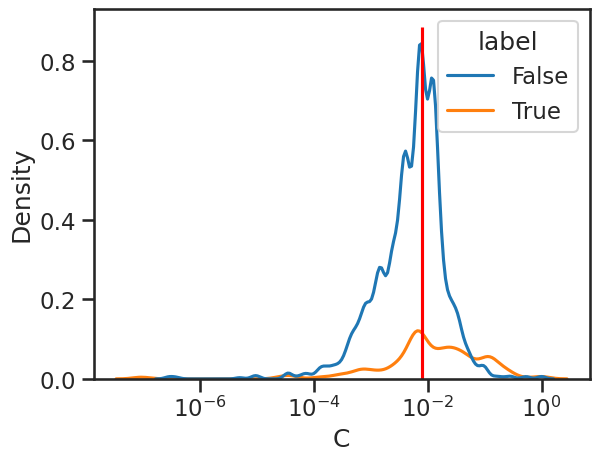

In [92]:
fig, ax =plt.subplots()
sns.kdeplot(data=logits_df, x='C', hue='label', log_scale=True, ax=ax, alpha=1.0, bw_adjust=0.5)
ax.vlines(x=[1/128], ymin=0.0, ymax=ax.get_ylim()[1], color='red')

In [82]:
1/128

0.0078125

## Attention mechanism

The logits, embeddings, and attention was computed in the main pipeline for the test set. Currently final layer only.

In [35]:
import datasets
import duckdb as ddb
db = ddb.connect('../data/database.ddb', read_only=True)

In [3]:
ds = datasets.load_from_disk('../data/nomelt-model/test_embeddings')

In [36]:
seqs = pd.DataFrame({'seqs': ds['meso_seq'] + ds['thermo_seq']})
seqs

,seqs
0,MGRSLKKGPFADDHLLKKIEVLNEGDKKQVVKTWSRRSTIFPTFIG...
1,MVDDEAYLAELVATALRYEGFETAVAHDGAGTEAQVAAFAPHLIVL...
2,MRLRIAYTKIEDARYIAHLDLTRVFERAIRRSGIHMSYSEGFNPRP...
3,MQPVTIYTTPSCPYCRRAKALLGRKGVAFDEIDVSDRAKRAAMSDL...
4,MVKILVVDDEASIVTLLQFNIEKAGFEVVTAEDGSAGYELALSEKP...
...,...
69069,MAAAPEAEGERLVVLGRVSGLYGVRGWVRVYSYTEPREGILRYDPW...
69070,MKKPKVLIVDDNPAVLDGLKIILELENFEVVSLCTNAKEAIEFLEK...
69071,MKKVLIVDDAAFVRYSLRQTLEKYGFEVVGEACDGKSCIKLFQQLR...
69072,MIKVVIVDDQKILTEGLKMVLSKKEEIEVCGIALDGDEAYMVCKKT...


In [37]:
db.execute("CREATE OR REPLACE TEMP TABLE seqs AS SELECT * FROM seqs")

In [40]:
id_map = db.execute("SELECT pid, protein_seq FROM proteins INNER JOIN seqs ON (seqs.seqs=proteins.protein_seq)").df()

In [45]:
id_map = id_map.drop_duplicates(subset=['protein_seq']).set_index('protein_seq')['pid'].to_dict()

In [46]:
db.close()

### Are there residues within the meso sequence that experience a lot of attention, both by other meso tokens and by thermo tokens?

This might indicate which positions in the protein to focus on, or are being targeted for change by the model.

In [140]:
def get_net_enc_attention_vectors(example):
    encoder_attention = example['encoder_attentions']

    # sum over heads
    encoder_attention = encoder_attention.sum(axis=0)

    # sum over attended to
    encoder_attention = encoder_attention.sum(axis=0)

    example['encoder_net_attention'] = encoder_attention

    return example

In [ ]:
ds = ds.map(get_net_enc_attention_vectors, num_proc=8)    

Map (num_proc=8):   0%|          | 0/34537 [00:00<?, ? examples/s]

In [ ]:
ds.saave_to_disk('./tmp/attention_data')

### Let's find the most aggressive residue switched made by the model

Eg. find residues that not only were altered from the meso seq by the model, but done so with high confidence.
first pivot to a dataset of residues

In [57]:
example = ds[1]

In [58]:
len(example['meso_seq'])

232

In [59]:
len(example['thermo_seq'])

224

In [61]:
example

{'meso_seq': 'MVDDEAYLAELVATALRYEGFETAVAHDGAGTEAQVAAFAPHLIVLDVMLPDGSGIDVCRRLRANGLRAPVIFLTARDATEDKVAGLTVGGDDYVTKPFSLEELVARVRAVLRRSGTGAPGATLGFADLEIDEDAHEVRRRGRPIALSPTEYKLLRYLVVNARKVLTKRQILDHVWEYDFNGNDGVVQTYISYLRRKVDAFDPPLIHTVPRVGYVLRTPDRPDGPPGTGKAR',
 'thermo_seq': 'MDRILVVDDDPSVTSLLKRGLAYEGFAVDTAASGEEALKIAREQPPDLVILDIMMPGMDGMEVLRRLRAADPELPVLFLTARDAPADQVRGLEAGADDYVVKPFTFEVLVARVRALLRRRQAERPQVLRFADLVLDTGTYTARRGDREIHLTALEFKLLHEFMLHPRQVLNKDQLLERVWGYDFGGNANVLEVYVKQLRQKLEAEGEPRLIHTVRGVGYVLREG',
 'taxid': tensor(910347),
 'query_align_cov': tensor(0.9688),
 'subject_align_cov': tensor(0.9353),
 'bit_score': tensor(474),
 'scaled_local_symmetric_percent_id': tensor(0.4518),
 'meso_seq_len': tensor(232),
 'thermo_seq_len': tensor(224),
 'seq_len_diff': tensor(8),
 'meso_temp': tensor(37.),
 'thermo_temp': tensor(73.),
 'index': tensor(1336438),
 'cluster': tensor(-16721),
 'status_in_cluster': 'extreme',
 'encoder_embeddings': tensor([[-0.2495, -0.0571, -0.3117,  ...,  0.2464,  0.1007, -0.1607],


In [72]:
from transformers import T5Tokenizer
import torch
tokenizer = T5Tokenizer.from_pretrained('../data/nomelt-model/model')

In [75]:
import re
def prepare_string(string):
        out = ' '.join(string)
        out = re.sub(r"[UZOB]", "X", out)
        return out
def get_input_tokens(example):
    in_col, out_col = 'meso_seq', 'thermo_seq'

    in_seqs = prepare_string(example[in_col])
    out_seqs = prepare_string(example[out_col])

    # tokenize inputs and outputs
    model_inputs = tokenizer(in_seqs, max_length=250, padding='longest', truncation=True)
    decoder_input_ids = torch.tensor(tokenizer(out_seqs, max_length=250, padding='longest', truncation=True)['input_ids'])
    model_inputs['decoder_input_ids'] = decoder_input_ids

    input_ids = torch.tensor(model_inputs['input_ids'])
    attention_mask = torch.tensor(model_inputs['attention_mask'])
    decoder_input_ids = torch.tensor(model_inputs['decoder_input_ids'])

    return input_ids, decoder_input_ids
    

In [76]:
i, d = get_input_tokens(example)

/tmp/ipykernel_93223/3728062762.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoder_input_ids = torch.tensor(model_inputs['decoder_input_ids'])


In [81]:
tokenizer.decode(i)

2023-09-13 10:52:10.815114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 10:52:12.432140: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'M V D D E A Y L A E L V A T A L R Y E G F E T A V A H D G A G T E A Q V A A F A P H L I V L D V M L P D G S G I D V C R R L R A N G L R A P V I F L T A R D A T E D K V A G L T V G G D D Y V T K P F S L E E L V A R V R A V L R R S G T G A P G A T L G F A D L E I D E D A H E V R R R G R P I A L S P T E Y K L L R Y L V V N A R K V L T K R Q I L D H V W E Y D F N G N D G V V Q T Y I S Y L R R K V D A F D P P L I H T V P R V G Y V L R T P D R P D G P P G T G K A R</s>'

In [94]:
vocab = {v: k for k,v in tokenizer.get_vocab().items()}

In [127]:
vocab

{0: '<pad>',
 1: '</s>',
 2: '<unk>',
 3: '▁A',
 4: '▁L',
 5: '▁G',
 6: '▁V',
 7: '▁S',
 8: '▁R',
 9: '▁E',
 10: '▁D',
 11: '▁T',
 12: '▁I',
 13: '▁P',
 14: '▁K',
 15: '▁F',
 16: '▁Q',
 17: '▁N',
 18: '▁Y',
 19: '▁M',
 20: '▁H',
 21: '▁W',
 22: '▁C',
 23: '▁X',
 24: '▁B',
 25: '▁O',
 26: '▁U',
 27: '▁Z',
 28: '<extra_id_99>',
 29: '<extra_id_98>',
 30: '<extra_id_97>',
 31: '<extra_id_96>',
 32: '<extra_id_95>',
 33: '<extra_id_94>',
 34: '<extra_id_93>',
 35: '<extra_id_92>',
 36: '<extra_id_91>',
 37: '<extra_id_90>',
 38: '<extra_id_89>',
 39: '<extra_id_88>',
 40: '<extra_id_87>',
 41: '<extra_id_86>',
 42: '<extra_id_85>',
 43: '<extra_id_84>',
 44: '<extra_id_83>',
 45: '<extra_id_82>',
 46: '<extra_id_81>',
 47: '<extra_id_80>',
 48: '<extra_id_79>',
 49: '<extra_id_78>',
 50: '<extra_id_77>',
 51: '<extra_id_76>',
 52: '<extra_id_75>',
 53: '<extra_id_74>',
 54: '<extra_id_73>',
 55: '<extra_id_72>',
 56: '<extra_id_71>',
 57: '<extra_id_70>',
 58: '<extra_id_69>',
 59: '<extra

In [133]:
class ResidueView:
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset
        self.thermo_idx_map = self._build_index_map('thermo_seq')
        
    def _build_index_map(self, column):
        idx_map = {}
        running_idx = 0
        for i, val in enumerate(self.hf_dataset[column]):
            seq_len = len(val) + 1  # +1 to account for the stop token
            idx_map[i] = (running_idx, running_idx + seq_len)
            running_idx += seq_len
        return idx_map
    
    def get_residue(self, idx):
        map_to_use = self.thermo_idx_map

        for i, (start, end) in map_to_use.items():
            if start <= idx < end:
                local_idx = idx - start
                seq_row = self.hf_dataset[i]
                probs = torch.softmax(seq_row['logits'][local_idx], dim=0)
                return {
                    'meso': seq_row['meso_seq']+'$',
                    'thermo': seq_row['thermo_seq']+'$',
                    'residue_true': (seq_row['thermo_seq']+'$')[local_idx],
                    'residue_pred': vocab[int(torch.argmax(probs))],
                    'res_pos': local_idx,
                    'probs': probs,
                    'max_prob': max(probs), 
                    'embedding': seq_row['decoder_embeddings'][local_idx],
                    'encoder_embeddings': seq_row['encoder_embeddings'],
                    'decoder_attention': seq_row['decoder_attentions'][:, local_idx, :],
                    'cross_attention': seq_row['cross_attentions'][:, local_idx, :],
                }

    def iterate_residues(self):
        map_to_use = self.thermo_idx_map

        for i, (start, end) in map_to_use.items():
            for local_idx in range(end - start):
                yield self.get_residue(start + local_idx, seq_type)


In [129]:
viewer = ResidueView(ds)

In [130]:
viewer.thermo_idx_map

{0: (0, 93),
 1: (93, 318),
 2: (318, 548),
 3: (548, 623),
 4: (623, 848),
 5: (848, 1078),
 6: (1078, 1263),
 7: (1263, 1371),
 8: (1371, 1508),
 9: (1508, 1689),
 10: (1689, 1938),
 11: (1938, 2105),
 12: (2105, 2331),
 13: (2331, 2531),
 14: (2531, 2741),
 15: (2741, 2872),
 16: (2872, 2982),
 17: (2982, 3228),
 18: (3228, 3451),
 19: (3451, 3667),
 20: (3667, 3845),
 21: (3845, 4078),
 22: (4078, 4315),
 23: (4315, 4540),
 24: (4540, 4695),
 25: (4695, 4816),
 26: (4816, 5026),
 27: (5026, 5177),
 28: (5177, 5418),
 29: (5418, 5649),
 30: (5649, 5801),
 31: (5801, 6030),
 32: (6030, 6181),
 33: (6181, 6389),
 34: (6389, 6601),
 35: (6601, 6827),
 36: (6827, 7050),
 37: (7050, 7287),
 38: (7287, 7538),
 39: (7538, 7679),
 40: (7679, 7793),
 41: (7793, 7967),
 42: (7967, 8204),
 43: (8204, 8400),
 44: (8400, 8514),
 45: (8514, 8662),
 46: (8662, 8900),
 47: (8900, 9122),
 48: (9122, 9318),
 49: (9318, 9409),
 50: (9409, 9651),
 51: (9651, 9807),
 52: (9807, 10039),
 53: (10039, 1019

In [131]:
rdata = viewer.get_residue(100)

In [132]:
rdata

{'meso': 'MVDDEAYLAELVATALRYEGFETAVAHDGAGTEAQVAAFAPHLIVLDVMLPDGSGIDVCRRLRANGLRAPVIFLTARDATEDKVAGLTVGGDDYVTKPFSLEELVARVRAVLRRSGTGAPGATLGFADLEIDEDAHEVRRRGRPIALSPTEYKLLRYLVVNARKVLTKRQILDHVWEYDFNGNDGVVQTYISYLRRKVDAFDPPLIHTVPRVGYVLRTPDRPDGPPGTGKAR$',
 'thermo': 'MDRILVVDDDPSVTSLLKRGLAYEGFAVDTAASGEEALKIAREQPPDLVILDIMMPGMDGMEVLRRLRAADPELPVLFLTARDAPADQVRGLEAGADDYVVKPFTFEVLVARVRALLRRRQAERPQVLRFADLVLDTGTYTARRGDREIHLTALEFKLLHEFMLHPRQVLNKDQLLERVWGYDFGGNANVLEVYVKQLRQKLEAEGEPRLIHTVRGVGYVLREG$',
 'residue_true': 'D',
 'residue_pred': '▁R',
 'res_pos': 7,
 'probs': tensor([2.5330e-06, 1.9598e-02, 4.6607e-15, 2.0660e-02, 1.2753e-02, 4.5208e-02,
         1.4108e-02, 1.4736e-02, 5.6948e-01, 3.6832e-02, 2.7923e-02, 9.5804e-03,
         8.6660e-03, 1.5270e-02, 4.5639e-02, 8.3344e-03, 1.1781e-02, 6.6597e-03,
         6.1175e-02, 6.4719e-03, 1.5178e-02, 2.9443e-02, 5.3621e-03, 1.5138e-02,
         4.1186e-15, 3.3399e-15, 4.1754e-15, 5.5565e-15, 7.5694e-15, 2.6216e-15,
         4.4483e-15, 3.5927e-15, 5.1124e